In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph


In [2]:
from typing import Optional, List, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class CustomerInfoState(TypedDict):
    budget: Optional[str]
    project_title: Optional[str]
    messages: List[str]
    interaction_count: int


In [3]:
def check_info_complete():
    """Check if we have all required information"""
    def _check(state: CustomerInfoState) -> str:
        print("---Checking Information Completeness---")
        
        has_budget = state.get('budget') is not None and state.get('budget').strip() != ""
        has_project_title = state.get('project_title') is not None and state.get('project_title').strip() != ""
        
        messages = state.get('messages', [])
        
        if has_budget and has_project_title:
            print(f"✅ All information collected!")
            print(f"   Budget: {state['budget']}")
            print(f"   Project Title: {state['project_title']}")
            return "complete"
        else:
            missing = []
            if not has_budget:
                missing.append("budget")
            if not has_project_title:
                missing.append("project title")
            print(f"❌ Missing: {', '.join(missing)}")
            return "ask_questions"
    
    return _check

def ask_questions():
    """Ask predefined questions for missing information"""
    def _ask(state: CustomerInfoState) -> dict:
        print("---Asking Questions---")
        
        messages = state.get('messages', [])
        interaction_count = state.get('interaction_count', 0) + 1
        
        # Predefined questions
        questions = []
        
        if not state.get('budget') or state.get('budget').strip() == "":
            questions.append("💰 What is your budget for this project?")
        
        if not state.get('project_title') or state.get('project_title').strip() == "":
            questions.append("📋 What is the title/name of your project?")
        
        question_text = "\n".join([f"{i+1}. {q}" for i, q in enumerate(questions)])
        
        if interaction_count == 1:
            greeting = "Hello! I need to collect some information about your project."
        else:
            greeting = "I still need some additional information."
            
        full_message = f"{greeting}\n\n{question_text}"
        
        print(full_message)
        messages.append(full_message)
        
        return {
            "messages": messages,
            "interaction_count": interaction_count
        }
    
    return _ask

def collect_info():
    """Simulate collecting information from user (in real app, this would be user input)"""
    def _collect(state: CustomerInfoState) -> dict:
        print("---Collecting User Response---")
        
        # Simulate user responses based on interaction count
        # In a real application, this would come from user input
        interaction_count = state.get('interaction_count', 0)
        
        if interaction_count == 1:
            # First interaction - provide both answers
            simulated_budget = "$50,000"
            simulated_project_title = "E-commerce Website Redesign"
            print(f"User provided: Budget='{simulated_budget}', Project Title='{simulated_project_title}'")
            return {
                "budget": simulated_budget,
                "project_title": simulated_project_title
            }
        elif interaction_count == 2:
            # Second interaction - provide missing info (if any)
            updates = {}
            if not state.get('budget'):
                updates['budget'] = "$25,000"
                print(f"User provided budget: {updates['budget']}")
            if not state.get('project_title'):
                updates['project_title'] = "Mobile App Development"
                print(f"User provided project title: {updates['project_title']}")
            return updates
        else:
            # Fallback for additional interactions
            return {}
    
    return _collect

def complete():
    """Final node when all information is collected"""
    def _complete(state: CustomerInfoState) -> dict:
        print("---Information Collection Complete---")
        
        summary = f"""
🎉 Thank you! I've collected all the required information:

📋 Project Title: {state['project_title']}
💰 Budget: {state['budget']}

We can now proceed with your project!
        """
        
        print(summary)
        
        messages = state.get('messages', [])
        messages.append(summary)
        
        return {"messages": messages}
    
    return _complete


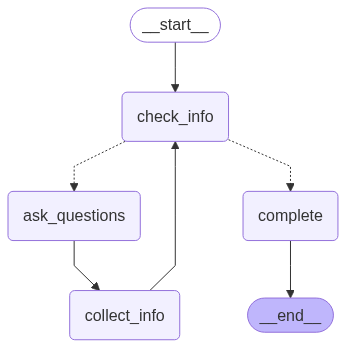

In [4]:
# Build the graph
builder = StateGraph(CustomerInfoState)

# Add nodes
builder.add_node("check_info", check_info_complete())
builder.add_node("ask_questions", ask_questions())
builder.add_node("collect_info", collect_info())
builder.add_node("complete", complete())

# Add edges
builder.add_edge(START, "check_info")

# Conditional edges from check_info
builder.add_conditional_edges(
    "check_info",
    lambda state: check_info_complete()(state),  # This returns "ask_questions" or "complete"
    {
        "ask_questions": "ask_questions",
        "complete": "complete"
    }
)

# Flow from ask_questions -> collect_info -> check_info (loop)
builder.add_edge("ask_questions", "collect_info")
builder.add_edge("collect_info", "check_info")

# End at complete
builder.add_edge("complete", END)

# Compile the graph
graph = builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))
